In [1]:
!pip install transformers datasets torch


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
from datasets import Dataset
import torch

In [3]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import torch
import re

# Load the Quora Question Answer dataset
dataset = load_dataset('toughdata/quora-question-answer-dataset')

# Initialize tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Normalize punctuation function
def normalize_punctuation(text):
    text = re.sub(r'[^\w\s\.?!"]', '', text)
    text = re.sub(r'\s([?.!;:])', r'\1', text)
    text = re.sub(r'([?.!;:])', r' \1 ', text)
    text = re.sub(r'“|”', '"', text)
    text = re.sub(r'‘|’', "'", text)
    text = re.sub(r'–', '-', text)
    text = re.sub(r'—', '-', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Preprocess function
def preprocess_function(examples):
    questions = [normalize_punctuation(q) for q in examples['question']]
    answers = [normalize_punctuation(a) for a in examples['answer']]
    inputs = [f"question: {q} context: {a}" for q, a in zip(questions, answers)]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding='max_length')
    labels = tokenizer(answers, max_length=512, truncation=True, padding='max_length')

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Split dataset into training and evaluation sets
split_dataset = tokenized_datasets['train'].train_test_split(test_size=0.1)
train_dataset = split_dataset['train']
eval_dataset = split_dataset['test']

# Convert processed data to Dataset object
def create_dataset(tokenized_data):
    return Dataset.from_dict({
        'input_ids': tokenized_data['input_ids'],
        'attention_mask': tokenized_data['attention_mask'],
        'labels': tokenized_data['labels']
    })

train_dataset = create_dataset(train_dataset)
eval_dataset = create_dataset(eval_dataset)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/56402 [00:00<?, ? examples/s]

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Load pre-trained T5 model
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [6]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=1000,
    save_total_limit=2,
    remove_unused_columns=False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [7]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)


In [9]:
torch.cuda.empty_cache()

In [8]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.043500,0.020205


TrainOutput(global_step=12691, training_loss=0.10620143400786106, metrics={'train_runtime': 4611.0183, 'train_samples_per_second': 11.009, 'train_steps_per_second': 2.752, 'total_flos': 6870085184520192.0, 'train_loss': 0.10620143400786106, 'epoch': 1.0})

In [9]:
# Evaluate the model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.020205410197377205, 'eval_runtime': 158.8779, 'eval_samples_per_second': 35.505, 'eval_steps_per_second': 8.881, 'epoch': 1.0}


In [10]:
# Save the model and tokenizer
model.save_pretrained('./fine_tuned_t5_model')
tokenizer.save_pretrained('./fine_tuned_t5_model')


('./fine_tuned_t5_model/tokenizer_config.json',
 './fine_tuned_t5_model/special_tokens_map.json',
 './fine_tuned_t5_model/spiece.model',
 './fine_tuned_t5_model/added_tokens.json')

In [11]:
!nvidia-smi


Tue Jul 30 08:19:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0              28W /  70W |   4813MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset
import torch

# Define the device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the fine-tuned model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('./fine_tuned_t5_model').to(device)
tokenizer = T5Tokenizer.from_pretrained('./fine_tuned_t5_model')

def get_answer(question, context):
    input_text = f"question: {question} context: {context}"
    inputs = tokenizer(input_text, return_tensors='pt', max_length=512, truncation=True).to(device)
    outputs = model.generate(inputs['input_ids'], max_length=512, num_beams=5, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

# Load the dataset
#dataset = load_dataset('toughdata/quora-question-answer-dataset')

# Get a subset of the dataset
subset_size = 10
questions_subset = dataset['train']['question'][:subset_size]
contexts_subset = dataset['train']['answer'][:subset_size]

# Generate and print answers for the subset



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Question: Why whenever I get in the shower my girlfriend want to join?
Context: Isn’t it awful? You would swear that there wasn’t enough hot water to go around!

Answer: Isn’t it awful? You would swear that there wasn’t enough hot water to go around!


Question: What is a proxy, and how can I use one?
Context: A proxy server is a system or router that provides a gateway between users and the internet. Therefore, it helps prevent cyber attackers from entering a private network. It is a server, referred to as an “intermediary” because it goes between end-users and the web pages they visit online.
 When a computer connects to the internet, it uses an IP address. This is similar to your home’s street address, telling incoming data where to go and marking outgoing data with a return address for other devices to authenticate. A proxy server is essentially a computer on the internet that has an IP address of its own.
 How a Proxy Works
Because a proxy server has its own IP address, it acts as

In [13]:
for question, context in zip(questions_subset, contexts_subset):
    answer = get_answer(question, context)
    print("Question:", question)
    print("Answer:", answer)
    print("\n")
    

Question: Why whenever I get in the shower my girlfriend want to join?
Answer: Isn’t it awful? You would swear that there wasn’t enough hot water to go around!


Question: What is a proxy, and how can I use one?
Answer: A proxy server is a system or router that provides a gateway between users and the internet. Therefore, it helps prevent cyber attackers from entering a private network. It is a server, referred to as an “intermediary” because it goes between end-users and the web pages they visit online. When a computer connects to the internet, it uses an IP address. This is similar to your home’s street address, telling incoming data where to go and marking outgoing data with a return address for other devices to authenticate. A proxy server is essentially a computer on the internet that has an IP address of its own. How a Proxy Works Because a proxy server has its own IP address, it acts as a go-between for a computer and the internet. Your computer knows this address, and when you 

**Distribution Plot**


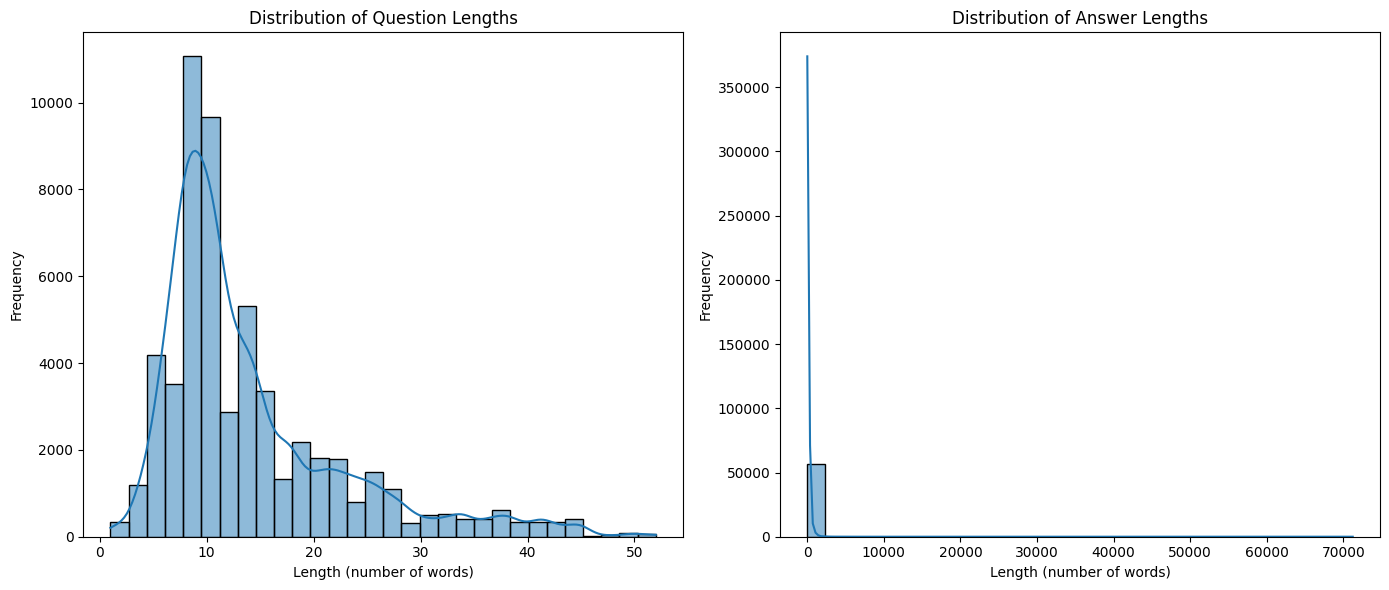

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load dataset
from datasets import load_dataset
dataset = load_dataset('toughdata/quora-question-answer-dataset')

# Convert to pandas DataFrame for easier handling
df = pd.DataFrame(dataset['train'])

# Calculate lengths of questions and answers
df['question_length'] = df['question'].apply(lambda x: len(x.split()))
df['answer_length'] = df['answer'].apply(lambda x: len(x.split()))

# Plot distribution of question and answer lengths
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['question_length'], kde=True, bins=30)
plt.title('Distribution of Question Lengths')
plt.xlabel('Length (number of words)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['answer_length'], kde=True, bins=30)
plt.title('Distribution of Answer Lengths')
plt.xlabel('Length (number of words)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**Feature  Importance**

In [16]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the fine-tuned model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('./fine_tuned_t5_model')
tokenizer = T5Tokenizer.from_pretrained('./fine_tuned_t5_model')

def get_attention_weights(question, context):
    input_text = f"question: {question} context: {context}"
    inputs = tokenizer(input_text, return_tensors='pt', max_length=512, truncation=True)

    # Get encoder outputs with attentions
    encoder_outputs = model.encoder(**inputs, output_attentions=True)
    encoder_attentions = encoder_outputs.attentions

    # Get decoder outputs with attentions
    decoder_outputs = model.decoder(
        input_ids=inputs['input_ids'],
        encoder_hidden_states=encoder_outputs.last_hidden_state,
        output_attentions=True
    )
    decoder_attentions = decoder_outputs.attentions

    return encoder_attentions, decoder_attentions

# Example usage
question = "What is a proxy server?"
context = "A proxy server is a system or router that provides a gateway between users and the internet."
encoder_attentions, decoder_attentions = get_attention_weights(question, context)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


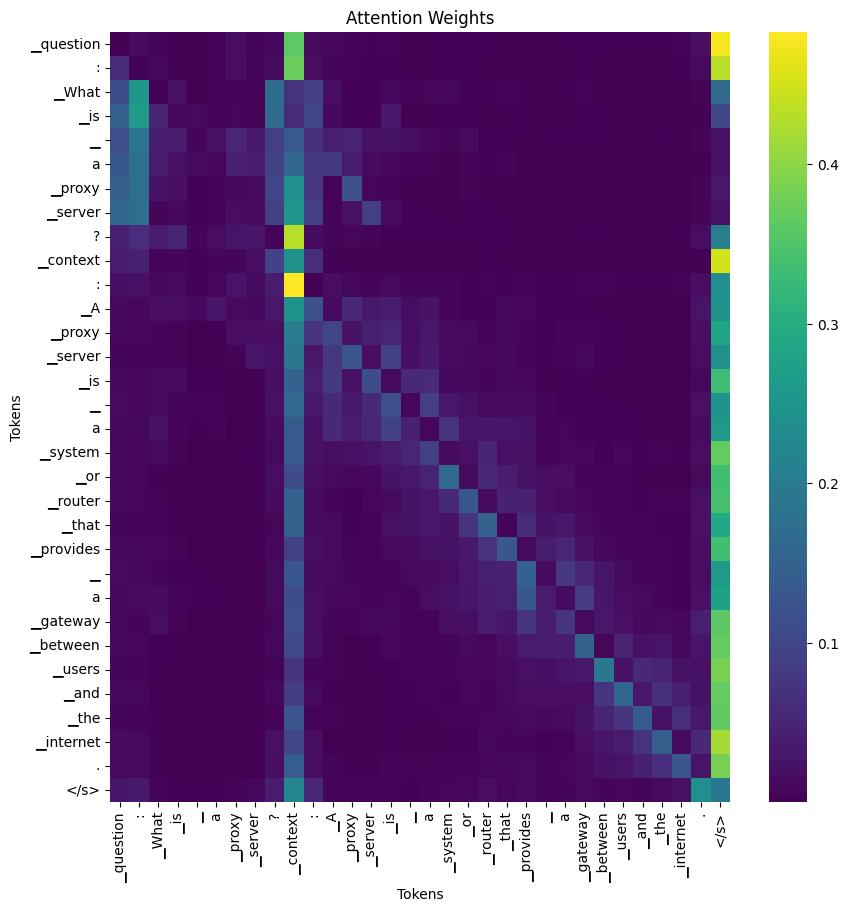

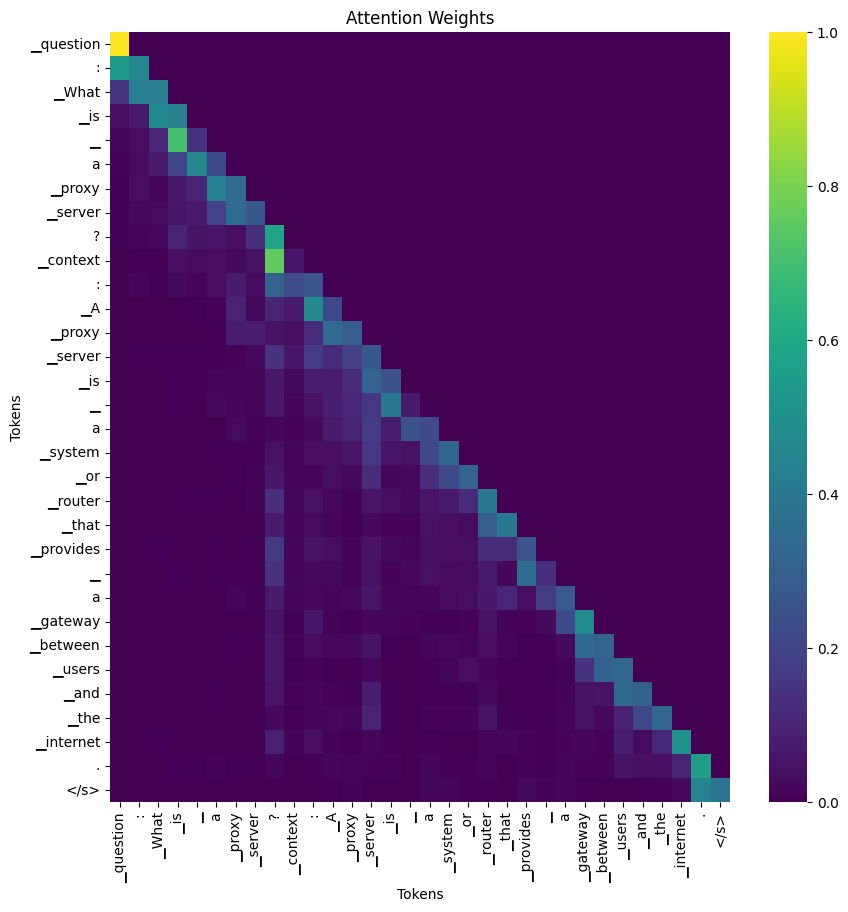

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(attentions, tokens):
    attention = attentions[-1][0]  # Use the last layer's attention
    attention = attention.mean(dim=0).squeeze().cpu().detach().numpy()  # Average attention heads

    # Plot heatmap of attention weights
    plt.figure(figsize=(10, 10))
    sns.heatmap(attention[:len(tokens), :len(tokens)], xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title('Attention Weights')
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.show()

# Tokenize input
input_ids = tokenizer.encode(f"question: {question} context: {context}", return_tensors='pt')[0]
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Visualize encoder attention weights
visualize_attention(encoder_attentions, tokens)

# Visualize decoder attention weights (using the same tokens for simplicity)
visualize_attention(decoder_attentions, tokens)


**Model Performance**

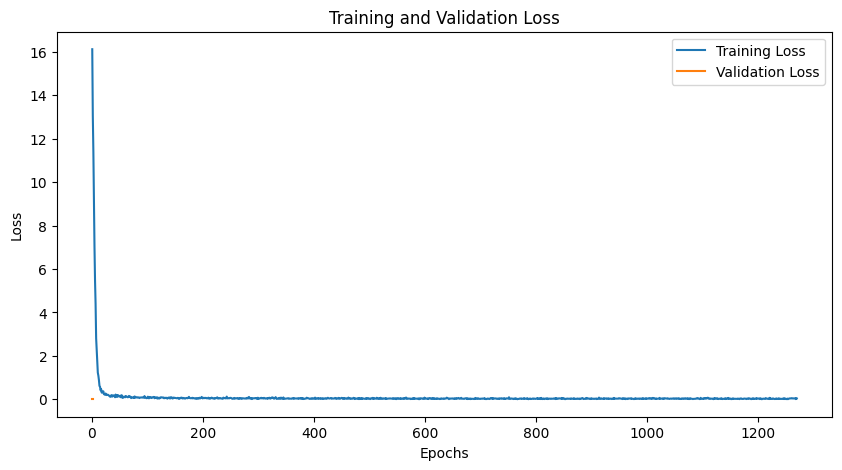

In [19]:
import matplotlib.pyplot as plt

# Extract training and evaluation loss
train_loss = [log['loss'] for log in training_logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]

# Create epoch range based on the length of the training loss
epochs_train = range(1, len(train_loss) + 1)
epochs_eval = range(1, len(eval_loss) + 1)

# Plot training and evaluation loss
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(epochs_train, train_loss, label='Training Loss')

# Plot evaluation loss only if it's available
if eval_loss:
    plt.plot(epochs_eval, eval_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
